.. _nb_custom:

## Custom Variable Type




In the following, we describe a custom variable problem. The variable is a string with a fixed length in our case. 
However, we formulate the problem to be easily extended to have a variable length.
The objective function looks as follows:

\begin{align}
\begin{split}
\max f_1(x) & = & \, \# a \\[2mm]
\max f_2(x) & = & \, \# b 
\end{split}
\end{align}

The first objective is the number of a's in the string and the second the number of b's.
For instance, for the variable "abdfgdgabb" the $f_1(x)=2$ and $f_2(x)=3$.


In [1]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, n_characters=10):
        super().__init__(n_var=1, n_obj=2, n_ieq_constr=0)
        self.n_characters = n_characters
        self.ALPHABET = [c for c in string.ascii_lowercase]

    def _evaluate(self, x, out, *args, **kwargs):
        n_a, n_b = 0, 0
        for c in x[0]:
            if c == 'a':
                n_a += 1
            elif c == 'b':
                n_b += 1

        out["F"] = np.array([- n_a, - n_b], dtype=float)



The problem definition above defines a problem with just one variable. This variable can be considered a complex object, which is, in our case, a string. The same principle can be used to use other data structures such as trees or lists with variable lengths. Because both objectives have to be maximized, we are minimizing their negative values.

To solve the optimization problem, evolutionary operators sampling, crossover, mutation, and duplication, check needs to be implemented.
Each of the modules will be shown in the following.

### Sampling

Our sampling method just generates a random string, which is equivalent to choosing a random letter from the alphabet (only lower case).
Because of the implementation of having only one variable, we return a matrix with the shape (n,1).

In [2]:
from pymoo.core.sampling import Sampling

class MySampling(Sampling):

    def _do(self, problem, n_samples, **kwargs):
        X = np.full((n_samples, 1), None, dtype=object)

        for i in range(n_samples):
            X[i, 0] = "".join([np.random.choice(problem.ALPHABET) for _ in range(problem.n_characters)])

        return X


### Crossover


The crossover operator combines parents to create offsprings. In our framework, the crossover operator retrieves the input already with predefined matings. 
Our crossover randomly picks a character from the first or the second parent.

In [3]:
from pymoo.core.crossover import Crossover

class MyCrossover(Crossover):
    def __init__(self):
        
        # define the crossover: number of parents and number of offsprings
        super().__init__(2, 2)

    def _do(self, problem, X, **kwargs):
        
        # The input of has the following shape (n_parents, n_matings, n_var)
        _, n_matings, n_var = X.shape
        
        # The output owith the shape (n_offsprings, n_matings, n_var)
        # Because there the number of parents and offsprings are equal it keeps the shape of X
        Y = np.full_like(X, None, dtype=object)

        # for each mating provided
        for k in range(n_matings):
            
            # get the first and the second parent
            a, b = X[0, k, 0], X[1, k, 0]
            
            # prepare the offsprings
            off_a = ["_"] * problem.n_characters
            off_b = ["_"] * problem.n_characters
            
            for i in range(problem.n_characters):
                if np.random.random() < 0.5:
                    off_a[i] = a[i]
                    off_b[i] = b[i]
                else:
                    off_a[i] = b[i]
                    off_b[i] = a[i]

            # join the character list and set the output
            Y[0, k, 0], Y[1, k, 0] = "".join(off_a), "".join(off_b)
            
        return Y

### Mutation


The mutation needs to be implemented for our string object as well. We either change the order of the string (40%), randomly pick a new character with a given probability (40%), or leave the string unmodified (20%). 

In [4]:
from pymoo.core.mutation import Mutation

class MyMutation(Mutation):
    def __init__(self):
        super().__init__()

    def _do(self, problem, X, **kwargs):
        
        # for each individual
        for i in range(len(X)):
            
            r = np.random.random()
            
            # with a probabilty of 40% - change the order of characters
            if r < 0.4:
                perm = np.random.permutation(problem.n_characters)
                X[i, 0] = "".join(np.array([e for e in X[i, 0]])[perm])
                
            # also with a probabilty of 40% - change a character randomly
            elif r < 0.8:
                prob = 1 / problem.n_characters
                mut = [c if np.random.random() > prob 
                       else np.random.choice(problem.ALPHABET) for c in X[i, 0]]
                X[i, 0] = "".join(mut)

        return X

### Duplicates


Moreover, do not underestimate the importance of filtering out duplicates during evolution. Duplicate elimination helps to make sure a mating produces an offspring that does not already exist in the current population. If it does, another mating process is triggered until unique individuals do exist.

In [5]:
from pymoo.core.duplicate import ElementwiseDuplicateElimination

class MyDuplicateElimination(ElementwiseDuplicateElimination):

    def is_equal(self, a, b):
        return a.X[0] == b.X[0]


### Optimize

Finally, we create an algorithm object with all the modules defined above.

In [6]:
import string
import numpy as np

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize


algorithm = NSGA2(pop_size=11,
                  sampling=MySampling(),
                  crossover=MyCrossover(),
                  mutation=MyMutation(),
                  eliminate_duplicates=MyDuplicateElimination())

res = minimize(MyProblem(),
               algorithm,
               ('n_gen', 100),
               seed=1,
               verbose=False)


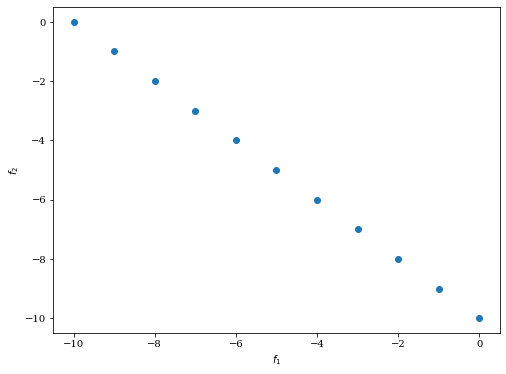

In [7]:
from pymoo.visualization.scatter import Scatter
Scatter().add(res.F).show()

In [8]:
results = res.X[np.argsort(res.F[:, 0])]
count = [np.sum([e == "a" for e in r]) for r in results[:, 0]]
print(np.column_stack([results, count]))

[['aaaaaaaaaa' 10]
 ['aaaaaaaaba' 9]
 ['baaaaaaaba' 8]
 ['aabbbaaaaa' 7]
 ['abbaabbaaa' 6]
 ['babbababaa' 5]
 ['aaabbbabbb' 4]
 ['abbbbababb' 3]
 ['baabbbbbbb' 2]
 ['bbabbbbbbb' 1]
 ['bbbbbbbbbb' 0]]
